# Model BCI Challenge

Before starting, make sure your environment is activated:

In [1]:
!conda env list

# conda environments:
#
base                     C:\Users\Erick\anaconda3
bci-env               *  C:\Users\Erick\anaconda3\envs\bci-env



## Modules

In [1]:
# Utilities
import pandas as pd
import numpy as np
import multiprocessing as mp
from pickle import dump, load

# To plot charts
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

## To handle missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor

# For modeling
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans

In [2]:
import sys
sys.path.append('../src/')

import utils

## Importing data

In [3]:
train = pd.read_csv('../data/input/train_data.csv')

In [4]:
train.head()

,id,mes,tipo_ban,tipo_seg,categoria,tipo_com,tipo_cat,tipo_cli,VAR1_sum,VAR1_prom,...,VAR27_sum,VAR27_prom,VAR27_trx,VAR28_sum,VAR28_prom,VAR28_trx,VAR29_prom,VAR29_ratio,VAR30_sum,target_mes
0,abdd0c8d3be5,202002,BAN1,NO PROD3,V5,COM4,RUBRO5,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
1,5b290c34ff68,202006,BAN1,PROD1,V2,COM2,RUBRO5,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17081.5,0.034,NaN,6.19
2,54b8678ab09b,201901,BAN1,PROD1/PROD2,V4,COM3,RUBRO3,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,706250.0,0.706,NaN,22.78
3,77e1b37ea594,202004,BAN1,NO PROD3,V6,COM4,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7632694.0,0.954,NaN,55.06
4,7b6c7a3b57a9,202101,BAN1,PROD1,V2,COM2,RUBRO4,CLI2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,376664.0,0.443,70.0,0.19


## Settings

In [5]:
SEED = 42
PATH_OBJECTS_PREPROCESSING = '../preprocessing_objects/'

## Train-Test split

In [6]:
X = train.drop('target_mes', axis=1)
y = train.target_mes

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Preprocessing

Refer to EDA notebook for a better understanding about some actions carried out in this stage.

### Formating dates

In [8]:
X_train.drop('mes', axis=1, inplace=True)

### Removing features with missing values

To drop features with missing values before encoding and other processing functions helps reducing dimensionality and this latter leads to memory usage reduction, even before training the model. So, it is not necessary to keep features while dataset is processed so that, finally, these are dropped later.

In [9]:
columns_most_nan_values = utils.get_columns_with_nan_values(X_train)

print(columns_most_nan_values)
print('Length', len(columns_most_nan_values))

Index(['VAR23_sum', 'VAR23_prom', 'VAR23_trx', 'VAR25_sum', 'VAR25_prom',
       'VAR25_trx', 'VAR4_sum', 'VAR4_prom', 'VAR4_trx', 'VAR3_sum',
       'VAR3_prom', 'VAR3_trx', 'VAR29_prom', 'VAR29_ratio', 'VAR1_trx',
       'VAR1_prom', 'VAR1_sum', 'VAR24_sum', 'VAR24_trx', 'VAR24_prom',
       'VAR17_sum', 'VAR2_trx', 'VAR2_prom', 'VAR2_sum', 'VAR28_sum',
       'VAR28_prom', 'VAR28_trx', 'VAR7_trx', 'VAR7_prom', 'VAR7_sum',
       'VAR16_sum', 'VAR30_sum', 'VAR8_trx', 'VAR8_prom', 'VAR8_sum',
       'VAR27_sum', 'VAR27_prom', 'VAR27_trx', 'VAR26_sum', 'VAR26_prom',
       'VAR26_trx', 'VAR6_trx', 'VAR6_prom', 'VAR6_sum', 'VAR10_sum',
       'VAR9_prom', 'VAR9_sum', 'VAR9_trx'],
      dtype='object')
Length 48


Removing columns with most of missing value and "id" column:

In [10]:
X_train.drop(list(columns_most_nan_values)+['id'], axis=1, inplace=True)

In [11]:
print(X_train.shape)

(500768, 19)


### Encoding

Analysis for categorical features:

In [12]:
X_train.select_dtypes('object').head()

,tipo_ban,tipo_seg,categoria,tipo_com,tipo_cat,tipo_cli
0,BAN1,NO PROD3,V5,COM4,RUBRO5,CLI1
1,BAN1,PROD1/PROD4,V2,COM3,RUBRO15,CLI1
2,BAN1,NO PROD3,V3,COM4,RUBRO8,CLI1
3,BAN1,PROD1,V4,COM2,RUBRO5,CLI1
4,BAN1,NO PROD3,V2,COM4,RUBRO5,CLI1


The feature ```categoria``` looks like categorical ordinal since it refers to levels, the other categories can be encoded with one hot encodert.

#### Encoding ```categoria```

In [13]:
encoder_categoria = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype='int8')
X_train['categoria'] = encoder_categoria.fit_transform(X_train[['categoria']])

#### Encoding rest of categories

In [14]:
encoder_features = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='int8')

In [15]:
df_categorical = X_train.select_dtypes('object')

df_encoded_features = pd.DataFrame(encoder_features.fit_transform(df_categorical), 
                                   columns=encoder_features.get_feature_names_out())

In [16]:
X_train.drop(df_categorical.columns, axis=1, inplace=True)

In [17]:
print('Before concat()', X_train.shape)

Before concat() (500768, 14)


In [18]:
X_train = pd.concat([X_train, df_encoded_features], axis=1)

In [19]:
print('After concat()', X_train.shape)

After concat() (500768, 62)


Checking for non-existing categorical features:

In [20]:
print('Categorical features', (X_train.dtypes=='object').sum())

Categorical features 0


### Correlations

In [21]:
corr_features = utils.get_high_correlated_features(X_train, 'float64') + utils.get_high_correlated_features(X_train, 'int8')
print(corr_features)

['VAR13_sum', 'VAR15_sum', 'tipo_com_COM1', 'tipo_com_COM2', 'tipo_com_COM4', 'tipo_com_COM5', 'tipo_cli_CLI2']


In [22]:
X_train.drop(corr_features, axis=1, inplace=True)

### Imputing missing values

Current missing values:

In [23]:
train_nan = X_train.isna().sum()
train_nan = train_nan[train_nan>0]
print(train_nan)

VAR5_sum     129303
VAR5_prom    129303
VAR5_trx     129303
VAR11_sum     37253
VAR12_sum     37253
VAR14_sum     37253
VAR18_sum     37253
VAR19_sum     37253
VAR20_sum     37253
VAR21_sum     37253
VAR22_sum     37253
dtype: int64


Creating model to fit and transform based on an estimator:

In [24]:
%%time

iterativeImputer = IterativeImputer(
                        estimator=DecisionTreeRegressor(random_state=SEED),
                        random_state=SEED, 
                        verbose=2, 
                        max_iter=1
                    )

train_imputed = iterativeImputer.fit_transform(X_train)

[IterativeImputer] Completing matrix with shape (500768, 55)
[IterativeImputer] Ending imputation round 1/1, elapsed time 304.95
[IterativeImputer] Change: 37843880603.2147, scaled tolerance: 38116777.491000004 


C:\Users\Erick\anaconda3\envs\bci-env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Wall time: 5min 7s


**Assert**: If train dataset without imputation does not contain negative values, then imputed dataset should not also contain them either

In [25]:
assert (train_imputed<0).sum().sum() == (X_train<0).sum().sum(), 'Make sure the estimator used in iterative imputer predict positive values'

In [26]:
X_train_imputed = pd.DataFrame(train_imputed, columns=X_train.columns)

X_train_imputed['categoria'] = X_train_imputed['categoria'].astype('int8')

In [27]:
X_train_imputed.head()

,categoria,VAR5_sum,VAR5_prom,VAR5_trx,VAR11_sum,VAR12_sum,VAR14_sum,VAR18_sum,VAR19_sum,VAR20_sum,...,tipo_cat_RUBRO20,tipo_cat_RUBRO21,tipo_cat_RUBRO3,tipo_cat_RUBRO4,tipo_cat_RUBRO5,tipo_cat_RUBRO6,tipo_cat_RUBRO7,tipo_cat_RUBRO8,tipo_cat_RUBRO9,tipo_cli_CLI1
0,4,180519180.0,3630612.678,39.0,296921717.0,296921717.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,62090140.0,2869571.111,16.0,223154.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,70000.0,70000.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3,27159736.0,1044547.756,27.0,3341946.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,9639920.0,1606653.333,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Exporting assets

### Preprocessed datasets

In [28]:
X_train_imputed.to_csv('../data/preprocessed/X_train_preprocessed.csv', index=False)

### Preprocessing objects

In [29]:
dump(encoder_categoria, open(PATH_OBJECTS_PREPROCESSING+'encoder_categoria.pkl', 'wb'))
dump(encoder_features, open(PATH_OBJECTS_PREPROCESSING+'encoder_features.pkl', 'wb'))
dump(iterativeImputer, open(PATH_OBJECTS_PREPROCESSING+'iterativeImputer.pkl', 'wb'))

## Importing resources

### Datasets

In [8]:
saved_X_train = pd.read_csv('../data/preprocessed/X_train_preprocessed.csv')

In [9]:
saved_X_train.head()

,categoria,VAR5_sum,VAR5_prom,VAR5_trx,VAR11_sum,VAR12_sum,VAR14_sum,VAR18_sum,VAR19_sum,VAR20_sum,...,tipo_cat_RUBRO20,tipo_cat_RUBRO21,tipo_cat_RUBRO3,tipo_cat_RUBRO4,tipo_cat_RUBRO5,tipo_cat_RUBRO6,tipo_cat_RUBRO7,tipo_cat_RUBRO8,tipo_cat_RUBRO9,tipo_cli_CLI1
0,4,180519180.0,3630612.678,39.0,296921717.0,296921717.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,62090140.0,2869571.111,16.0,223154.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,70000.0,70000.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3,27159736.0,1044547.756,27.0,3341946.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,9639920.0,1606653.333,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Objects

In [8]:
saved_encoder_categoria = load(open(PATH_OBJECTS_PREPROCESSING+'encoder_categoria.pkl', 'rb'))
saved_encoder_features  = load(open(PATH_OBJECTS_PREPROCESSING+'encoder_features.pkl', 'rb'))
saved_iterativeImputer  = load(open(PATH_OBJECTS_PREPROCESSING+'iterativeImputer.pkl', 'rb'))

## Pipeline Preprocessing

In [9]:
def preprocess_data(df_test):
    X_test_copy = df_test    
    X_test_copy.reset_index(inplace=True, drop=True)
    
    # Transforming mes feature
    X_test_copy.drop('mes', axis=1, inplace=True)
    
    # Dropping features with missing values
    columns_most_nan_values = utils.get_columns_with_nan_values(X_test_copy)
    X_test_copy.drop(list(columns_most_nan_values)+['id'], axis=1, inplace=True)
    
    # Encoding categoria feature
    X_test_copy['categoria'] = saved_encoder_categoria.transform(X_test_copy[['categoria']])
    
    # Encoding other features
    df_categorical_test = X_test_copy.select_dtypes('object')

    df_features_test = pd.DataFrame(saved_encoder_features.transform(df_categorical_test), 
                                   columns=saved_encoder_features.get_feature_names_out())
    X_test_copy.drop(df_categorical_test.columns, axis=1, inplace=True)
    X_test_copy = pd.concat([X_test_copy, df_features_test], axis=1)

    # Correlations
    corr_features = utils.get_high_correlated_features(X_test_copy, 'float64') + utils.get_high_correlated_features(X_test_copy, 'int8')
    X_test_copy.drop(corr_features, axis=1, inplace=True)
    
    # Imputing missing values
    
    data_imputed = saved_iterativeImputer.transform(X_test_copy) 
    X_test_imputed = pd.DataFrame(data_imputed, columns=X_test_copy.columns)
    X_test_imputed['categoria'] = X_test_imputed['categoria'].astype('int8')
    
    return X_test_imputed

In [12]:
X_test_copy = preprocess_data(X_test)

[IterativeImputer] Completing matrix with shape (166923, 55)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.87


In [13]:
print(X_test_copy.shape)

(166923, 55)


## Model

### Training

In [14]:
model = RandomForestRegressor(verbose=1, random_state=SEED, n_jobs=mp.cpu_count())

In [15]:
%%time
model.fit(saved_X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.9min


Wall time: 4min 55s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.9min finished


RandomForestRegressor(n_jobs=8, random_state=42, verbose=1)

### Evaluating

In [16]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(saved_X_train).flatten()
    y_pred_test = model.predict(X_test_copy).flatten()

    # MAE metric
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('MAE Train', mae_train)
    print('MAE Test', mae_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


MAE Train 47.485106082059644
MAE Test 110.97997450125735


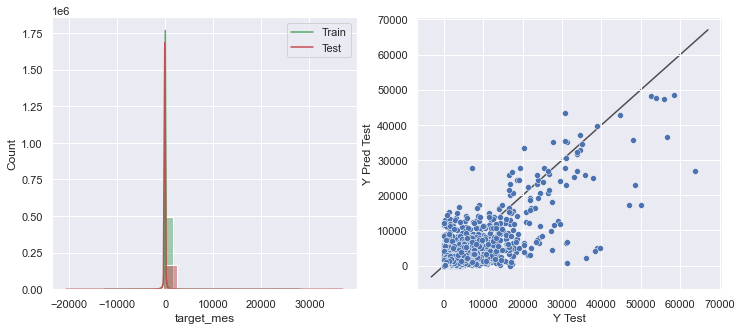

In [17]:
results_metric(model)

### Training with whole dataset

In [10]:
X_preprocessed = preprocess_data(X)

[IterativeImputer] Completing matrix with shape (667691, 55)
[IterativeImputer] Ending imputation round 1/1, elapsed time 3.61


In [11]:
%%time
model_full = RandomForestRegressor(
                              random_state=SEED, 
                              n_jobs=mp.cpu_count(), 
                              verbose=1)
model_full.fit(X_preprocessed, y)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.7min


Wall time: 7min 1s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  7.0min finished


RandomForestRegressor(n_jobs=8, random_state=42, verbose=1)

In [12]:
y_prediction = model_full.predict(X_preprocessed)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.7s finished


In [13]:
print(mean_absolute_error(y, y_prediction))

46.21570746396241


## Submission

In [18]:
test = pd.read_csv('../data/input/test_data.csv')
id = test.id
mes = test.mes

Applying preprocessing pipeline

In [19]:
test_preprocessed = preprocess_data(test)

[IterativeImputer] Completing matrix with shape (292016, 55)
[IterativeImputer] Ending imputation round 1/1, elapsed time 1.52


Predictions

In [16]:
predictions =  model_full.predict(test_preprocessed)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


Creating submission

In [20]:
df_submission = pd.DataFrame({
        'id': id,
        'mes': mes,
        'target_mes': predictions
    })

df_submission.to_csv('../submission/submission.csv', index=False)

## References

* https://machinelearningmastery.com/how-to-save-and-load-models-and-data-preparation-in-scikit-learn-for-later-use/